In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

# Import and normalize data

The dataset is available in my Zenodo account. For detailed information please check the dataset datasheet in the file "data_sheet.md". It consists on data files generated in Matlab (*.mat) and can be downloaded here:
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7818255.svg)](https://doi.org/10.5281/zenodo.7818255)

To load it into python we use the convinient "io" toolbox from the scipy package. It loads the data in the .mat file into a dictionary. In the following cell replace the paths according to the local folder to which you download the datasets.

In [ ]:
#load data from mat files
train_origin = loadmat('/data/brain_state_trainset.mat')

val_origin = loadmat('/data/brain_state_valset.mat')
test_origin = loadmat('/data/brain_state_testset.mat')

Check the content of the dictionaries. We are interested in the 'spectrograms', 'movement' and 'target' keys. For each instance, there is a spectrogram of the power spectral density of LFP in the hippocampus at different lags from the reference time point (+- 50 s window around it). Likewise, "movement" gives the temporal profile of the magnitude of movement at the same time windows. The target variable contains the corresponding brain state labels. Namely, Wake, Quiet Wake, non-REM sleep and REM sleep (please check the dataset datasheet for more detailed information).

In [7]:
#check the content of the dictionary
train_origin.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_movement', 'train_spectrograms', 'train_target'])

### Data normalization

We are looking for a model that generalizes well across animals. So, the predictions should be robust to inter-subject variations in the absolute values of input variables. Typically, the movement data is quite reproducible accross animals, whereas the LFP power can have significant inter-subject variability.
Regarding LFP power spectrograms, there are two options: normalize using whole spectral data statistics or normalize each spectral image (such that all images will be normalized to the same range). In order to maximize generazability, the latter option will be adopted here.

**Normalization of movement data**

The different modalities and formats of LFP spectrograms and movement inputs makes it difficult to choose a normalization method that optimally balances the contribution of the two modalities. To avoid model biases due to data inballances, I will test two machine learning algorithms that don't use distance-based metrics and, in general, don't require data normalization: decision trees and artificial neural networks. In any case, the movement data will be range-normalized.

In [5]:
from sklearn.preprocessing import RobustScaler

Create a function that normalizes movement using the RobustScaler function from sklearn. 
Each instance will be normalized using movement data from the whole train dataset.

In [328]:
x_norm = train_origin['train_movement'].flatten().reshape(-1,1)
moveScaler = RobustScaler(quantile_range=(10,90)).fit(x_norm)

Then we can define a function that normalizes both LFP power spectrograms and movement

In [615]:
def normalize_test(data_origin,spectr_field, mov_field, mov_scalefunc):

    """This function normalizes LFP power spectrogram and movement data. Input arguments:
    data_origin: dictionary extracted from Matlab containing the data
    spectr_field: name of the field of insterest in the dictionary for spectrograms
    mov_field: name of the field of insterest in the dictionary for movement
    mov_scalefunc: movement scaling function previously defined based on whole training set"""

    #normalize spectral data using a quantile-based method that is not sensitive to outliers
    def normfunc(x):
        #center and normalize data based on percentiles 10 and 90
        transf = RobustScaler(quantile_range=(10,90)).fit(x)
        return transf.transform(x)


    spectral_norm = np.zeros((np.shape(data_origin[spectr_field])[1],np.shape(data_origin[spectr_field])[0],
    np.shape(data_origin[spectr_field])[2]))
    
    #normalize movement
    mov_norm = mov_scalefunc.transform(data_origin[mov_field].flatten().reshape(-1,1))
    mov_norm = np.reshape(mov_norm,(np.shape(data_origin[mov_field])))
    mov_norm = np.transpose(mov_norm) #transpose to have it in the form instances x movement profiles

    #Normalize each spectrogram instance
    for i in range(np.shape(spectral_norm)[0]):
        #Convert power spectral values to logarithms to minimize sekewness
        spec = np.log(np.squeeze(data_origin[spectr_field][:,i,:]))
        spec = normfunc(spec.flatten().reshape(-1,1)) #normalize flattened multidimensional data
        
        #then recover the original format
        spectral_norm[i,:,:] = np.reshape(spec,(np.shape(spectral_norm)[1],np.shape(spectral_norm)[2]))
        
        #adjust some mov instances with negative values
        if np.quantile(mov_norm[i,:],0.15)<0:
            mov_norm[i,:] = mov_norm[i,:]-np.quantile(mov_norm[i,:],0.15)

    return spectral_norm, mov_norm

Normalize the data

In [616]:
spectral_norm_train, mov_norm_train = normalize_test(train_origin,'train_spectrograms','train_movement',moveScaler)
spectral_norm_val, mov_norm_val = normalize_test(val_origin, 'val_spectrograms', 'val_movement',moveScaler)
spectral_norm_test, mov_norm_test = normalize_test(test_origin, 'test_spectrograms', 'test_movement',moveScaler)

### Visualize samples from different classes
Next we check how the data looks like for the different brain state classes.

[[300, 31, 219, 89]]


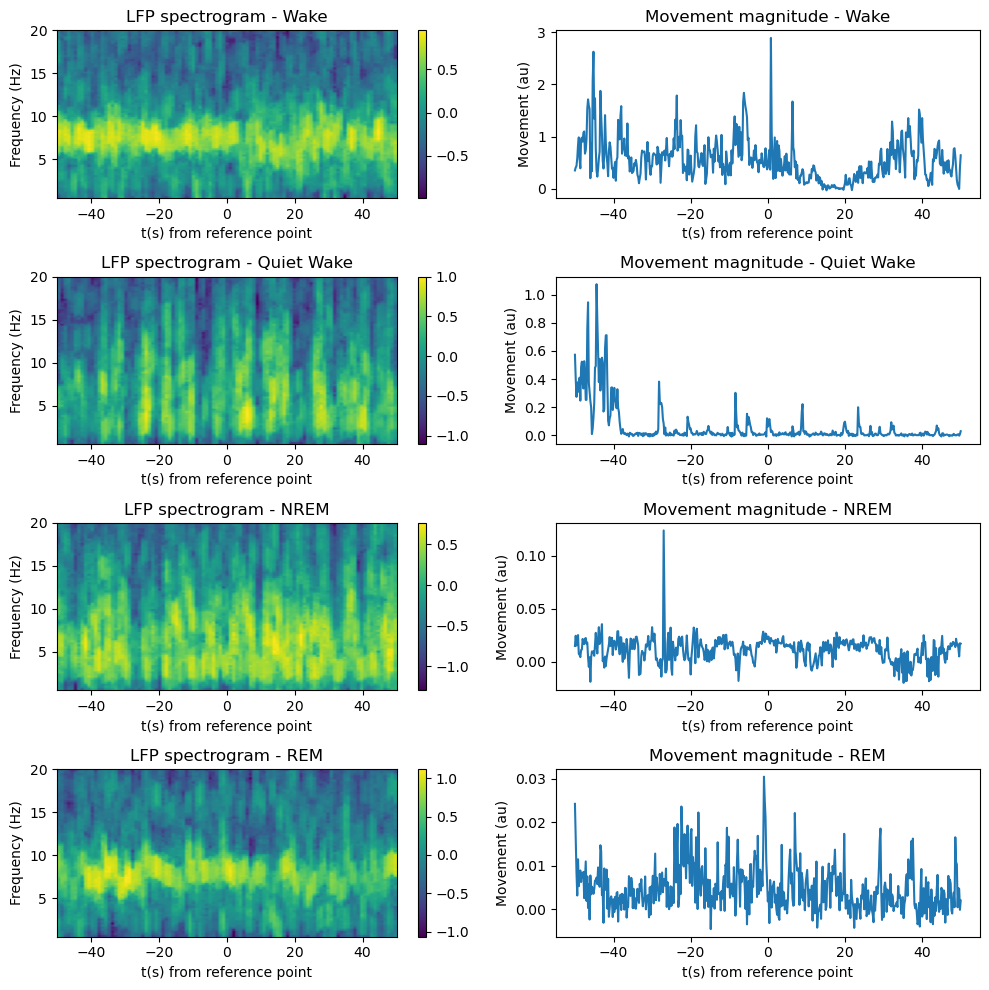

In [618]:
#pick indices corresponding to different classes
state_ind = [0, 0, 0, 0]
for i in np.arange(1,5):
    state_ind[i-1] = np.where(train_origin['under_train_target']==i)[0][np.random.randint(100)]

state_labels = ['Wake', 'Quiet Wake', 'NREM','REM']
fig, axs = plt.subplots(4,2, figsize=(10,10))

for i, labl in enumerate(state_labels):
    #plot spectral data
    pcm = axs[i,0].imshow(spectral_norm_train[state_ind[i],:,:].T, origin='lower',
    aspect='auto', extent=[-50,50,0.5,20])
    axs[i,0].set_title('LFP spectrogram - ' + labl)
    fig.colorbar(pcm, ax=axs[i,0])
    axs[i,0].set_xlabel('t(s) from reference point')
    axs[i,0].set_ylabel('Frequency (Hz)')
    
    #plot movement profile
    axs[i,1].plot(np.linspace(-50,50, num=501), mov_norm_train[state_ind[i],:])
    axs[i,1].set_title('Movement magnitude - ' + labl)
    axs[i,1].set_xlabel('t(s) from reference point')
    axs[i,1].set_ylabel('Movement (au)')

fig.tight_layout()
plt.show()

    

The examples ilustrate the difference in the patterns of LFP and movement across brain states. During Wake, the animal is moving (check magnitudes of movement) and there is a rythmic pattern of brain electrical activity in the hippocampus. It is called theta oscillation and underlies the spectral band visible at 6-10 Hz. During quiet wake both patterns are less accentuated and during NREM sleep there is little movement and no prominent theta band in LFP. This is distinct from the REM sleep patterns, showing strong theta in the absence of mevement.

## Correct unballanced data

An important aspect when dealing with data used in machine learning projects is whether the dataset is ballanced. Let's check how instances are distributed accross classes.

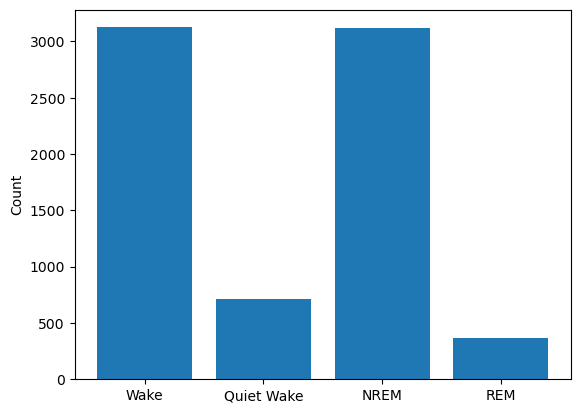

In [ ]:
counts_target,bins = np.histogram(train_origin['train_target'],bins=np.arange(0.5,5.5))
plt.bar(state_labels,counts_target)
plt.ylabel('Count')
plt.show()

The data is unballanced. To correct that we will use undersampling as shown below.

In [9]:
def resample(data, spectra, mov, target_field,sampling='under'):
        """Function used to balance data by under- or over-sampling
        data: dictionary from Matlab import containing the data
        spectra: normalized spectrogram data
        mov: normalized movement data
        target_field: field in the dictionary containing labels
        sampling specifies whether the undersample or oversample"""

        from imblearn.over_sampling import RandomOverSampler
        from imblearn.under_sampling import RandomUnderSampler

        #The oversampling function only accepts instance x features format as inputs, 
        # so we need to reshape spectral data and concatenate it with movement
        X_data = np.concatenate((mov, spectra.reshape(len(mov),
                np.shape(spectra)[1]*np.shape(spectra)[2])),axis=1)
        y_data = data[target_field].ravel()

        #instantiate oversampler and apply it
        if sampling=='under':
                ros = RandomUnderSampler(random_state=34)
        elif sampling=='over':
                ros = RandomOverSampler(random_state=34)

        X_res, target_res = ros.fit_resample(X_data, y_data)

        #recover original data formats
        mov_norm_res = X_res[:,:np.shape(mov)[1]]
        spectral_norm_res = np.reshape(X_res[:, np.shape(mov)[1]:],
                (len(mov_norm_res),np.shape(spectra)[1],np.shape(spectra)[2]))

        return spectral_norm_res, mov_norm_res, target_res


Resample the data

In [337]:
spectral_norm_train_res, mov_norm_train_res, target_train_res = resample(train_origin,spectral_norm_train, mov_norm_train,'train_target','under')
spectral_norm_val_res, mov_norm_val_res, target_val_res = resample(val_origin,spectral_norm_val, mov_norm_val,'val_target', 'under')

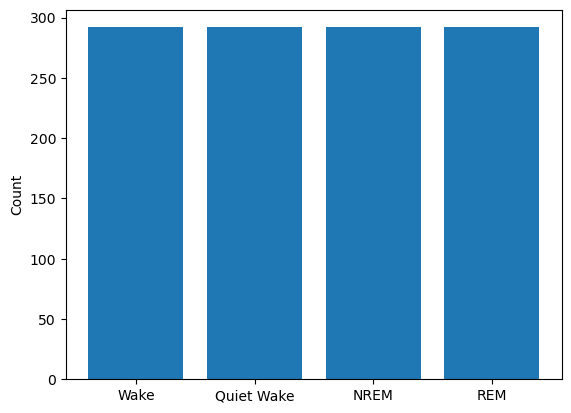

In [627]:
#confirm the new counts
counts_target,bins = np.histogram(target_val_res,bins=np.arange(0.5,5.5))
plt.bar(state_labels,counts_target)
plt.ylabel('Count')
plt.show()

## Create dataset object and random samplers

The dataset class from torch allows convenient storage and sampling of the data, particularly useful for neural network training.
First we need to create a class that will allow sampling batches of the dataset.

In [12]:
class DataStates(Dataset):
    def __init__(self, movement, spec, labels):
        self.labels = labels
        self.movement = movement
        self.spec = spec

    def __len__(self):
        return len(self.movement)

    def __getitem__(self, index):
        X1 = self.movement[index,:]
        X2 = self.spec[index,:,:]
        y = self.labels[index]
        return X1, X2, y


If a GPU is available the data is loaded into the GPU. We will use a dedicated dataset class for that.

In [ ]:

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")

In [13]:
class DataStatesCUDA(Dataset):
    def __init__(self, movement, spec, labels):
        self.labels = labels
        self.movement = movement
        self.spec = spec

    def __len__(self):
        return len(self.movement)

    def __getitem__(self, index):
        X1 = self.movement[index, :,:]
        X2 = self.spec[index, :, :,:]
        y = self.labels[index]-1
        return X1, X2, y


Then we create the dataset objects.

In [623]:
#Create datasets
#move training data to GPU
l1 = np.shape(mov_norm_train_res)
l2 = np.shape(spectral_norm_train_res)
mov_norm_trainCUDA = torch.tensor(mov_norm_train_res.reshape((l1[0],1,l1[1])),dtype=torch.float,device=dev)
spectral_norm_trainCUDA = torch.tensor(spectral_norm_train_res.reshape((l2[0],1,l2[1],l2[2])),dtype=torch.float, device=dev)
target_trainCUDA = torch.tensor(target_train_res,dtype=torch.long, device=dev)
data_trainCUDA = DataStatesCUDA(mov_norm_trainCUDA, spectral_norm_trainCUDA, target_trainCUDA)

#the same for data in cpu
data_train = DataStates(mov_norm_train_res, spectral_norm_train_res, target_train_res)
data_val = DataStates(mov_norm_val_res, spectral_norm_val_res, target_val_res)
data_test = DataStates(mov_norm_test, spectral_norm_test, test_origin['test_target'].ravel())

# Make predictions using machine learning algorithms

I chose to address this problem using two approaches. The first is by means of a standard machine learning algorithm, namely decision tree. The decision tree (or tree ensembles) offers some advantages in the context of this challenge relative to other machine learning algorithms: it is non-parametric and it does not rely on distance-based metrics. This is particularly important in light of the multi-modal nature of this dataset, where ballancing the weigth of movement and brain activity features is not easily achieved solely by normalization. 

## Fit Random Forest Classifier

We start by fitting a random forest model, a popular tree ensemble algorithm that overcomes some drawbacks of single decision trees, notably overfitting.

In [15]:
from sklearn import tree, ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [80]:
def random_forest(data_train, n_train, data_val, n_val, params = []):
    """Function that applies a random foresst classifier to the data.
    Inputs:
    train_sampler: sampler used to load the training data
    n_train: size of train set to fit
    validation_sampler: sampler used to load the validation data
    n_val: size of validation set to fit
    params: If not empty, it should be a series with the values corresponding to the parameters
    in n_estimators, max_depth, min_samples_leaf, max_features and min_impurity_decrease"""

    #create dataloaders
    train_loader = DataLoader(data_train,batch_size=n_train)
    validation_loader = DataLoader(data_val,batch_size=n_val)

    traindata = iter(train_loader)
    traindata = traindata.next()

    #train the model
    #we need to reshape the data such data for each instance there is a single row with all the features
    X_train = np.concatenate((traindata[0], 
    traindata[1].reshape(n_train,np.shape(traindata[1])[1]*np.shape(traindata[1])[2])),axis=1)
    y_train = traindata[2].ravel()

    if len(params)==0:
        rf_clf = ensemble.RandomForestClassifier()
    else:
        #print('here')
        rf_clf = ensemble.RandomForestClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params["max_depth"]),
            min_samples_leaf=float(params['min_samples_leaf']),
            max_features=str(params['max_features']),
            min_impurity_decrease=float(params['min_impurity_decrease']))
            
    #fit the data
    rf_clf.fit(X_train,y_train)

    #get validation data
    valdata = iter(validation_loader)
    valdata = valdata.next()
    
    #reshape
    X_val = np.concatenate((valdata[0], 
    valdata[1].reshape(n_val,np.shape(valdata[1])[1]*np.shape(valdata[1])[2])),axis=1)
    y_val = valdata[2].ravel()

    #make predictions
    pred = rf_clf.predict(X_val)

    #compute performance metrics
    cm = confusion_matrix(y_val,pred)
    score = rf_clf.score(X_val,y_val)

    return cm, score, rf_clf


Run the function with default settings

In [624]:
cm_rf_default, score_rf_default,rf_clf_default = random_forest(data_train, len(data_train), data_val, len(data_val))

Accuracy of the random forest is 0.89


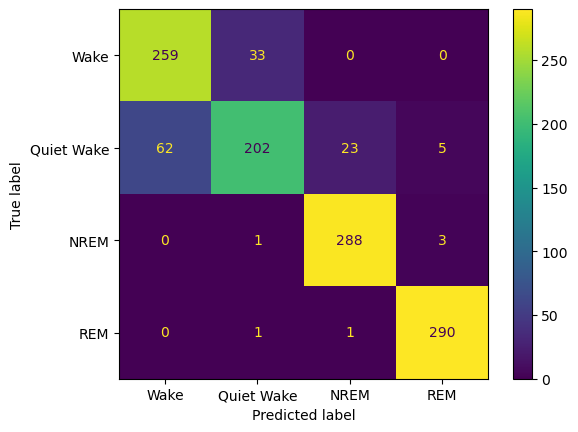

In [625]:
#Show performance
cmd_rf_default = ConfusionMatrixDisplay(cm_rf_default,display_labels=state_labels)
cmd_rf_default.plot();
print('Accuracy of the random forest is', np.round(score_rf_default,3))

It looks like we get quite a decent accuracy already with the default parameter values. Later we will tune the hyperparameters using Bayesian Optimisation.

# Build a neural network

Artificial neural networks have became popular due to their superior performance in solving complex problems. Among the many possible architectures, the convolutional neural networks (CNNs) are particularly suitable to deal with image formats of inputs. The CNNs hierarchical convolutions are able to capture important patterns in images while decreasing dimensionality. The end result is a model that learns to important features to solve the problem in a computational efficient way.
Here, I will design a CNN that operates on the bimodal inputs: the spectral images (2D) and movement (1D). The core idea is to pass the images throught two 2D convolution layers (with max pooling) whose output is fed into a series of fully connected layers until reaching the output layer. The movement 1D data will be addressed in parallel, passing though a 1D convolution filter (with max pooling). The inputs of 2D and 1D branches of the network intercept at the level of the first fully connected layer.

The network will be built applied using PyTorch.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Implement the neural network class**

In [628]:
class Net(nn.Module):
    def __init__(self, name=None, filter_size1d=5, filter_size=5, fc1_size=120, fc2_size=84,n_conv1=6,n_conv2=16,n_convtime=3):
        """Define the convolutional neural network.
        The parameters describing filter sizes and the number of neurons in the fully connected
        layers can be provided externally.
        """
        
        super(Net,self).__init__()
        if name:
            self.name=name
        
        #define input size of first fully connected layer depending on image resolution
        global pool2h, pool2w, pooltimew, num_conv2

        num_conv2 = n_conv2
        picres = torch.tensor([[101,81]]) #tensor with image resolution for spectral data

        pool1h = torch.floor(((picres[0][0]-(filter_size-1))-2)/2)+1 #height of 1st maxpool layer output
        pool2h = torch.floor(((pool1h-(filter_size-1))-2)/2)+1 #height of 2nd maxpool layer output
        pool1w = torch.floor(((picres[0][1]-(filter_size-1))-2)/2)+1 #width of 1st maxpool layer output
        pool2w = torch.floor(((pool1w-(filter_size-1))-2)/2)+1 #width of 2nd maxpool layer output
        
        #branch of spectral images
        self.conv1=nn.Conv2d(1,n_conv1,filter_size) #first convolutional layer
        self.pool=nn.MaxPool2d(2,2) #max-pooling parameters are fixed
        self.conv2=nn.Conv2d(n_conv1,n_conv2,filter_size) #second convolutional layer

        #branch of movement
        self.convtime = nn.Conv1d(1,n_convtime,filter_size1d) #1d convolutional layer 
        self.pooltime = nn.MaxPool1d(2,2) #max-pooling
        pooltimew = torch.floor(((torch.tensor(501)-(filter_size1d-1))-2)/2)+1 #width of the max-pool output

        #fully connected layers
        #the first layer gets the inputs of the 2D branch concatenated with those from the 1D branch
        self.fc1=nn.Linear(int(n_conv2*pool2h.item()*pool2w.item())+int(n_convtime*pooltimew.item()),fc1_size)
        self.fc2=nn.Linear(fc1_size,fc2_size) #second fully connected layer
        self.fc3=nn.Linear(fc2_size,4) #output layer
        

    def forward(self, x, x2):
        #x denotes the spectral inputs and x2 denotes movement inputs
        #the output of all convolution layers passes trhough a ReLu activation function
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, int(num_conv2*pool2h.item()*pool2w.item()))
        x2 = self.pooltime(F.relu(self.convtime(x2)))
        x2 = x2.reshape(np.shape(x2)[0],np.shape(x2)[1]*np.shape(x2)[2])
        
        #the output of the 2 fully connect hidden-layers goes through ReLu activation
        x = F.relu(self.fc1(torch.concat((x, x2),dim=1)))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x)) #output layer
        return x

## Training the neural network

### Training function

In [666]:
def trainNet(net, data_train, batch_size=10, epochs=4, epoch_start=0, printr=False, save_loss=False):
    """Function to train the neural network
        Inputs:
            net: network to train
            batch_size: size of the mini-batch used in the SGD optimization
            epochs: number of traning epochs
            epoch start: number of epochs run so far + 1. Used to keep track of total training
                epochs when the function takes an already pretrained network as input
            printr: boolean to determine whether running loss is displayed during execution
            save_loss: boolean used to indicate wheter to store information about the running loss"""
 
    net = net.float()
    net.to(dev)

    # create training loader
    trainloader = DataLoader(data_train,batch_size=int(batch_size))

    #train
    import time 
    start = time.time()
    global loss
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        epoch_start += 1
        running_loss = 0.0
        rloss = []
        
        for i, sample in enumerate(trainloader):
            
            # zero the parameter gradients
            optimizer.zero_grad()

            #compute network output
            outputs=net(sample[1],sample[0])
            
            #print(np.shape(sample[2]))
            #calculate loss (criterion is a global variable initialized externaly)
            loss = criterion(outputs, sample[2])
            
            #update weights based on backpropagation
            loss.backward()
            optimizer.step()

            if save_loss:
                rloss.append(loss.item())

            if printr:
                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every 10 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0
    
    end = time.time()

    if printr:
        print('Finished Training')
        print('training time ', end-start)
    
    if save_loss:
        return rloss

### Save checkpoint function

Function used to save current model state and related parameters into a file.

In [22]:
def SaveCheckpoint(tuning, path):
    torch.save({
        'tuned_parameters': tuning.best_x,
        'tuning_data': tuning,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    },path)

### Checkpoint function

Function used to instantiate the intialize either a new neural network or taking a pre-saved model 

In [787]:
def Checkpoint(path, name=None, filter_size1d=5, filter_size=5, fc1_size=120, fc2_size=84, lr=0.0005,n_conv1=6,n_conv2=16,n_convtime=3):
    """Function used to instantiate the intialize either a new neural network or taking a pre-saved model
            Inputs:
                path: path of the file containing model information(saved with the SaveCheckpoint function
                name: network name
                filter_size1d, filter_size, fc1_size, fc2_size are network hyperparameters
                lr: learning rate"""
                
    #instantiate neural network
    global net,criterion,optimizer,epoch_start
    
    #print(filter_size1d)
    net = Net(name, filter_size1d, filter_size, fc1_size, fc2_size, n_conv1, n_conv2, n_convtime).float().to(dev)
    
    #create optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,10,1,1],dtype=torch.float,device=dev))
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.95)
    
    if path == '':
        epoch_start = 0
        #loss = torch.zeros(1,requires_grad=True)
    else:
        checkpt = torch.load(path)
        filter_size1d=int(checkpt['tuned_parameters']['filter_size1d'])
        filter_size = int(checkpt['tuned_parameters']['filter_size'])
        fc1_size = int(checkpt['tuned_parameters']['fc1_size'])
        fc2_size = int(checkpt['tuned_parameters']['fc2_size'])
        print(filter_size1d)
        net = Net(name, filter_size1d, filter_size, fc1_size, fc2_size)
        
        net.load_state_dict(checkpt['model_state_dict'])
        optimizer.load_state_dict(checkpt['optimizer_state_dict'])
        #epoch_start = checkpt['epoch']
        loss = checkpt['loss']
        net.train()

### Network test function

Next, we define a function to run to test the predictive performance of the CNN on the validation and test sets.

In [558]:
def test(net, data,batch_size=10, printr=False):
    """Function to test neural network predictions on a given dataset
            Inputs:
                net: Network to test
                sampler: Subset random sampler used to sample validation or test sets
                batch_size: size of batchs to compute predictions on
                printr: Whether to show performance results"""

    testloader = DataLoader(data,batch_size=batch_size)
    net = net.float()
    net.to(torch.device('cpu'))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for sample in testloader:
            l1 = np.shape(sample[0])
            l2 = np.shape(sample[1])
            #reshaope input data to approppriate format
            input_mov = torch.tensor(sample[0].reshape((l1[0],1,l1[1])),dtype=torch.float)
            input_spec = torch.tensor(sample[1].reshape(l2[0],1,l2[1],l2[2]),dtype=torch.float)
            labels = sample[2]-1
            
            #compute predictions from the class with max output
            outputs=net(input_spec,input_mov)
            predicted = np.argmax(outputs,axis=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    #compute confusion matrix
    cm = confusion_matrix(labels,predicted)
    
    if printr:
        print(cm)
        print('Accuracy:\nTotal:', 100*correct/total, '\nWake:',cm[0,0]/np.sum(cm[0,:]),'\nQuiet wake:',
        cm[1,1]/np.sum(cm[1,:]),'\nNREM:', cm[2,2]/np.sum(cm[2,:]),'\nREM:', cm[3,3]/np.sum(cm[3,:]))
        
    return cm, 100*correct/total, predicted, outputs

Using the 3 functions above we can run trainin either from scratch or from an already pretrained model. We can then test the accuracy of the CNN as exemplified below.

In [ ]:
Checkpoint('', name='Net-Capstone', lr=0.0005, n_conv1=11,n_conv2=9,n_convtime=2,fc1_size=800,fc2_size=700, filter_size=14, filter_size1d=14)
trainNet(net,data_trainCUDA, epochs=300,batch_size=100,printr=True)

In [ ]:

test(net,data_val, batch_size=len(data_val),printr=True)

# Hyperparameter tuning with HEBO

In order to maximize the performance of the models, it is important to tune their hyperparameters. However, evaluation of machine learning models can be computationaly expensive, particularly in the case of artificial neural networks. Therefore, in order to minimize the time and resources spent in hyperparameter tuning, it is critical to use a data guided approach such as Bayesian Optimisation (BO). In this section, I will use a state-of-the-art Baysian Optimisation algorithm named HEBO (standing for Heteroscedastic Evolutionary Bayesian Optimisation). This algorithm was developed by a HUAWEI team, who won a NeurIPS black-box competion. It improves some limitations of standard BO by assuming non-stationarity and complex amplitude-dependent noise of the black-box function (for details please check the package repository under https://github.com/huawei-noah/HEBO/tree/master/HEBO).

## Tune the neural network

In [27]:
from hebo.optimizers.hebo import HEBO
from hebo.optimizers.bo import BO
from hebo.optimizers.hebo_embedding import HEBO_Embedding
from hebo.design_space.design_space import DesignSpace

### Wraper function to use in the tuning

It is useful to define a function that returns the performance of the CNN on the validation set, given a set of hyperparameter values.

In [448]:
def netlearn(filter_size1d=3, filter_size=3, fc1_size=120, fc2_size=84, lr=0.001, epochs=100, batch_size=100,n_conv1=16,n_conv2=6,n_convtime=3):
    
    Checkpoint('', name='Net-Capstone', filter_size1d=filter_size1d,
     filter_size=filter_size, fc1_size=fc1_size, fc2_size=fc2_size, lr=lr, n_conv1=n_conv1,n_conv2=n_conv2,n_convtime=n_convtime)
    
    trainNet(net, data_trainCUDA, epochs=epochs, batch_size=batch_size)
    _,performance = test(net,data_val, batch_size=len(data_val))
    
    return performance
    

Design the input space 

In [453]:
space = DesignSpace().parse([{'name':'filter_size1d','type':'int','lb': 3, 'ub': 20},
                            {'name':'filter_size','type':'int','lb': 5, 'ub': 20},
                            {'name':'fc1_size','type':'int','lb': 100, 'ub': 800},
                           {'name':'fc2_size','type':'int','lb': 80, 'ub': 700},
                           {'name':'n_conv1','type':'int','lb': 6, 'ub': 16},
                           {'name':'n_conv2','type':'int','lb': 3, 'ub': 10},
                           {'name':'n_convtime','type':'int','lb': 1, 'ub': 5},
                           ])

#Instantiate HEBO optimizer
hebo = HEBO(space)

In [456]:
#Define wrapper function
def obj(X):
    return netlearn(filter_size1d=X.iloc[0,0],filter_size=X.iloc[0,1],
     fc1_size=X.iloc[0,2],fc2_size=X.iloc[0,3],n_conv1=X.iloc[0,4],n_conv2=X.iloc[0,5],n_convtime=X.iloc[0,6])

Run Bayesian Optimization

In [ ]:
for i in range(50):
    x_rec = hebo.suggest() #suggest new data point based on observations made so far
    hebo.observe(x_rec,-np.reshape(obj(x_rec),(-1,1))) #add new data point
    if i % 1 == 0:
        print('Iter %d, best_y = %.2f, y = %.2f' % (i, -hebo.y.min(),-hebo.y[i]))

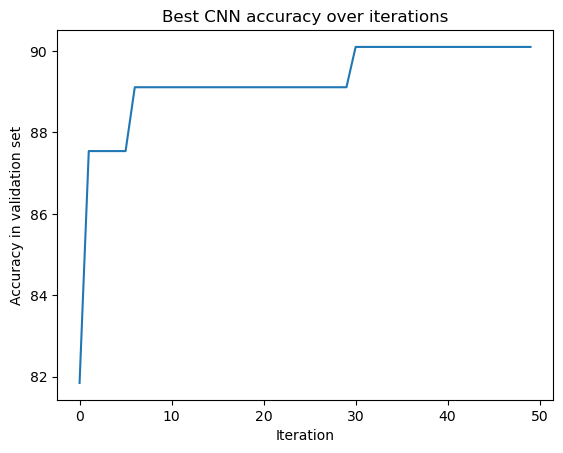

In [459]:
#Plot the change of the best accuracy over iterations
plt.plot(range(len(hebo.y)), -np.minimum.accumulate(hebo.y))
plt.title('Best CNN accuracy over iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy in validation set')
plt.show()

It seems that we got quite a good performance after BO. Let's check the hyperparameter values that led to the best accuracy.

In [460]:
hebo.best_x

,filter_size1d,filter_size,fc1_size,fc2_size,n_conv1,n_conv2,n_convtime
30,14,14,492,541,11,9,2


### Save the model

After optimization it is a good time to save the model

In [464]:
#save model checkpoint
path_check = 'D:/Ricardo/code/brain_states/net-brain_states.pt'
SaveCheckpoint(hebo,path_check)

## Tune the random forest

We tune the random forest classifier the same way as we did with the CNN.

In [803]:
#Create optimisation space object for HEBO 
space_rf = DesignSpace().parse([{'name':'n_estimators','type':'cat','categories': [100, 200, 500, 1000]},
                            {'name':'max_depth','type':'int','lb': 5, 'ub': 30},
                            {'name':'min_samples_leaf','type':'num','lb': 1e-5, 'ub': 0.1},
                            {'name':'max_features','type':'cat','categories': ['log2', 'sqrt']},
                           {'name':'min_impurity_decrease','type':'pow','lb': 1e-5, 'ub': 0.1},
                           ])

#Instantiate the HEBO optimiser
hebo_rf = HEBO(space_rf)

#Define a wrapper function to evaluate the random forest classifier 
def obj(X):
    _, perf,_ = random_forest(data_train, len(data_train),data_val, len(data_val),(X.iloc[0,:]))
    return perf

Run Bayesian Optimisation

In [ ]:
for i in range(50):
    x_rec = hebo_rf.suggest()
    hebo_rf.observe(x_rec,-np.reshape(obj(x_rec),(-1,1)))
    if i % 1 == 0:
        print('Iter %d, best_y = %.2f, y = %.2f' % (i, -hebo_rf.y.min(),-hebo_rf.y[i]))

### Check results

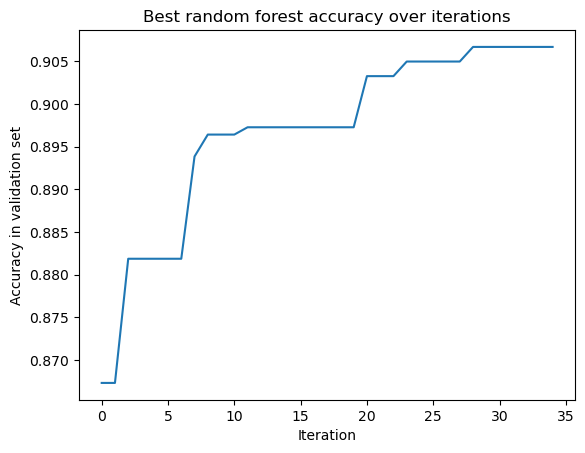

In [805]:
#Plot the change of the best accuracy over iterations
plt.plot(range(len(hebo_rf.y)), -np.minimum.accumulate(hebo_rf.y))
plt.title('Best random forest accuracy over iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy in validation set')
plt.show()

In [806]:
#Check the hyperparameter values that gave the best accuracy
hebo_rf.best_x

,max_depth,min_samples_leaf,min_impurity_decrease,n_estimators,max_features
28,28,0.00001,0.000012,1000,sqrt


# Model selection

After tuning both models, we can now compare their performance in the test set.

### Test models' predictive performance on the test set

For the random forest model

In [810]:
cm_rf_test, accuracy_rf_test, best_rf = random_forest(data_train, len(data_train), data_test, len(data_test), hebo_rf.best_x.iloc[0,:])

Accuracy of the Random Forest is 0.938


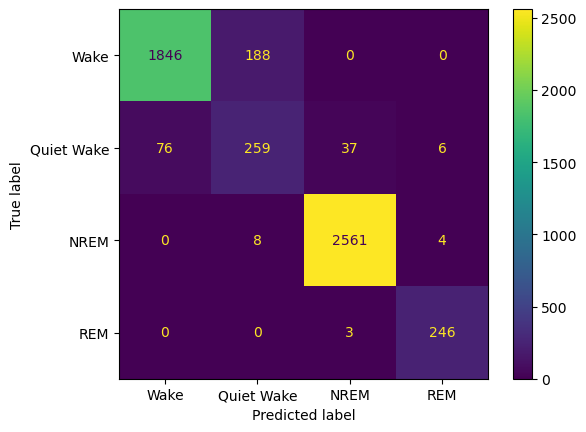

In [811]:
#Show performance
cmd_rf_test = ConfusionMatrixDisplay(cm_rf_test,display_labels=state_labels)
cmd_rf_test.plot();
print('Accuracy of the Random Forest is', np.round(accuracy_rf_test,3))

For the neural network

In [ ]:
#test performance in test set
cm_CNNtest, acc_CNNtest = test(net,data_test, batch_size=len(data_test))

Accuracy of the CNN on the test set is 91.842


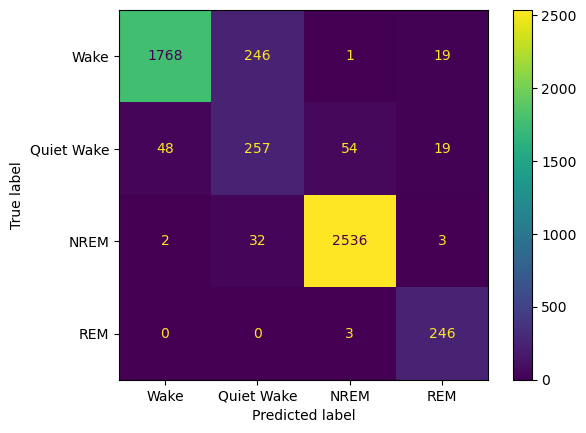

In [466]:
#Show performance
cmd_CNNtest = ConfusionMatrixDisplay(cm_CNNtest,display_labels=state_labels)
cmd_CNNtest.plot();
print('Accuracy of the CNN on the test set is', np.round(acc_CNNtest,3))

### Compare accuracy accross states

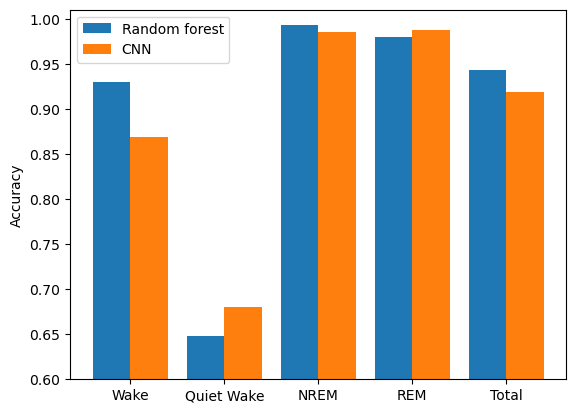

In [468]:
#Get accuracies by brain state
def GetAccState(cm):
    return np.diag(cm)/np.sum(cm,axis=1)

x_axis = np.arange(5)

accplotCNN = np.append(GetAccState(cm_CNNtest),acc_CNNtest/100)
accplot_rf = np.append(GetAccState(cm_rf_test),accuracy_rf_test)

labels_plot = ['Wake', 'Quiet Wake', 'NREM', 'REM','Total']

plt.bar(x_axis-0.2, accplot_rf, width=0.4, label='Random forest')
plt.bar(x_axis+0.2, accplotCNN, width=0.4, label='CNN')
plt.xticks(x_axis, labels_plot)
plt.ylim((0.6,1.01))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# External test set

To further test how well these models generalize across animals, we can test them on data from an animal that was not used in the training set.

## Load and normalize data

In [351]:
#load data from mat file
extest_origin = loadmat('z:/ricardo/data/Project/State_classification/brain_state_test.mat')

spectral_norm_extest, mov_norm_extest = normalize_test(extest_origin,'spectrograms_test','movement_test',moveScaler)
target_extest = extest_origin['target_test'].ravel()

#create dataset for test set
data_extest = DataStates(mov_norm_extest, spectral_norm_extest,target_extest)

## Test Random Forest performance on external test set

In [357]:
cm_rf_tuned_extest, acc_rf_tuned_extest,_ = random_forest(data_train, len(data_train), data_extest, len(data_extest), hebo_rf.best_x.iloc[0,:])

Accuracy of the Random Forest is 0.819


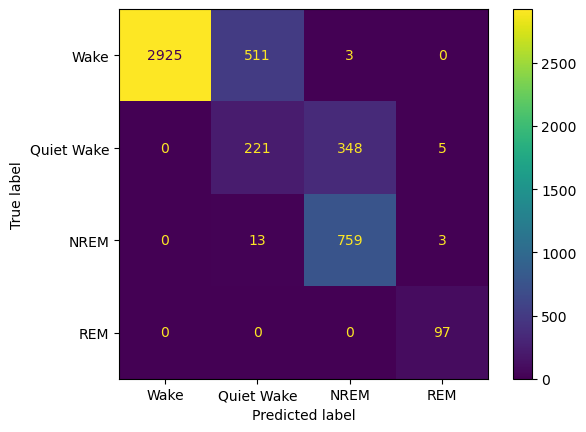

In [358]:
#Show performance
cmd_rf_tuned_extest = ConfusionMatrixDisplay(cm_rf_tuned_extest,display_labels=state_labels)
cmd_rf_tuned_extest.plot();
print('Accuracy of the Random Forest is', np.round(acc_rf_tuned_extest,3))

## Test neural network performance

In [469]:
#test performance in test set
cm_CNNextest, acc_CNNextest = test(net, data_extest, batch_size=len(data_extest))

Accuracy of the CNN on the test set is 74.882


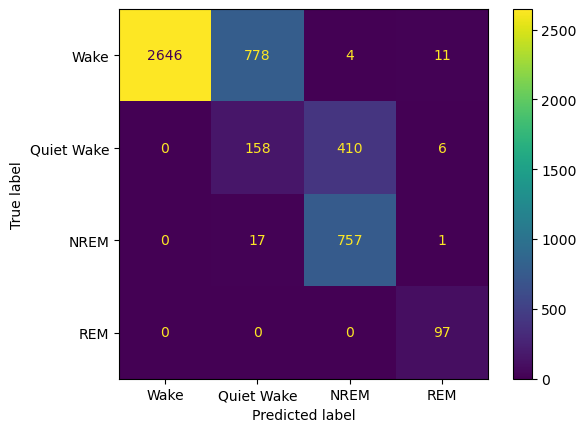

In [470]:
#Show performance
cmd_CNNextest = ConfusionMatrixDisplay(cm_CNNextest,display_labels=state_labels)
cmd_CNNextest.plot();
print('Accuracy of the CNN on the test set is', np.round(acc_CNNextest,3))

# Check wrong predictions

In order to improve the model predictions, it is important to figure out the reasons that led to wrong predictions. In this section we have a quick look at some instances that were wrongly predicted to see if there is a common pattern among them.

### Random Forest

We create a wrapper function to make it easier to get predictions from the rf model.

In [472]:
def rf_predict(data_val,n_val, rf_clf):
    validation_loader = DataLoader(data_val,batch_size=n_val)

    valdata = iter(validation_loader)
    valdata = valdata.next()
    
    #reshape
    X_val = np.concatenate((valdata[0], 
    valdata[1].reshape(n_val,np.shape(valdata[1])[1]*np.shape(valdata[1])[2])),axis=1)
    y_val = valdata[2].ravel()

    #make predictions
    pred = rf_clf.predict(X_val)
    
    return pred

Create a function that shows the spectrograms and movement profiles of wrongly classified instances.

In [575]:
def checkWrong(pred,y,pred_state, y_state, spect, mov):
    """Function that plots wrongly predicted instances.
    pred: predictions(indices from 0 to 3, original labels-1)
    y: brain state labels (indices from 0 to 3, original labels-1)
    pred_state: predicted state (indices from 0 to 3)
    y_state: actual state (indices from 0 to 3)
    spect: spectrogram data
    mov: movement data"""

    print(pred_state, y_state)
    comp = np.array(pred==pred_state).reshape(-1,1)
    comp2 = np.array(y==y_state).reshape(-1,1)
    cmpt = np.sum(np.concatenate((comp,comp2),axis=1),axis=1)
    #print(np.shape(comp+comp2)[0])
    #print(np.shape(np.where(cmpt==2)[0]))
    len_evs = np.shape(np.where(np.logical_and(pred==pred_state,y==y_state))[0])[0]
    print(len_evs)

    wrong_ind = np.where(np.logical_and(pred==pred_state,y==y_state))[0][np.random.randint(len_evs,size=4)]
    print(wrong_ind)
    
    fig, axs = plt.subplots(4,2, figsize=(10,10))
    state_labels = ['Wake', 'Quiet Wake', 'NREM','REM']

    for i in range(4):
        #plot spectral data
        pcm = axs[i,0].imshow(spect[wrong_ind[i],:,:].T, origin='lower',
            aspect='auto', extent=[-50,50,0.5,20])
        axs[i,0].set_title('LFP spectrogram - ' + 'Predicted ' + state_labels[pred[wrong_ind[i]]] + ', Truth ' + state_labels[y[wrong_ind[i]]])
        fig.colorbar(pcm, ax=axs[i,0])
        axs[i,0].set_xlabel('t(s) from reference point')
        axs[i,0].set_ylabel('Frequency (Hz)')
    
        #plot movement profile
        axs[i,1].plot(np.linspace(-50,50, num=501), mov[wrong_ind[i],:])
        axs[i,1].set_title('Movement magnitude')
        axs[i,1].set_xlabel('t(s) from reference point')
        axs[i,1].set_ylabel('Movement (au)')

    fig.tight_layout()
    plt.show()

In [813]:
rf_predictions = rf_predict(data_val,len(data_val),best_rf)

0 1
56
[568 554 564 478]


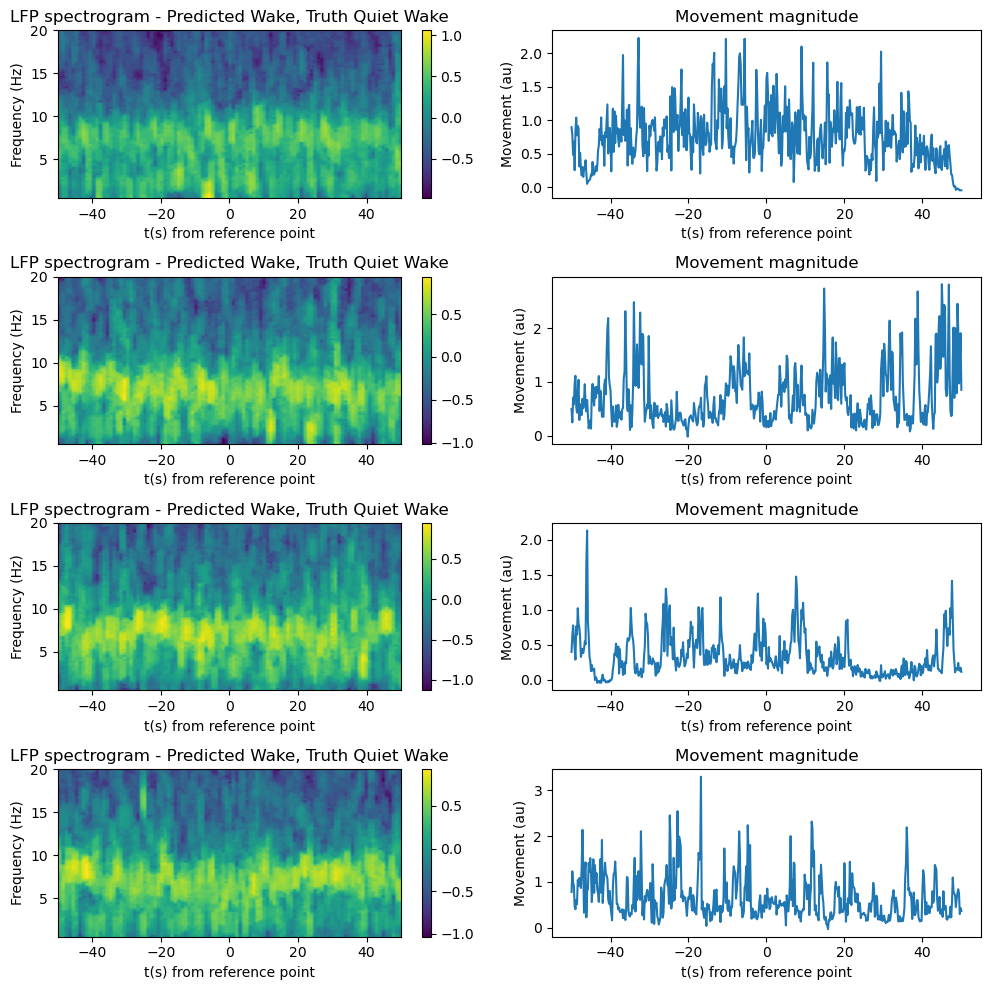

In [819]:
checkWrong(rf_predictions-1,target_val_res-1,0,1,spectral_norm_val_res,mov_norm_val_res)

### Neural network

Create a function that shows the spectrograms and movement profiles of wrongly classified instances.

In [737]:
def checkWrongNet(pred,y,pred_state, y_state, spect, mov, output):
    """Function that plots wrongly predicted instances.
        pred: predictions(indices from 0 to 3, original labels-1)
        y: brain state labels (indices from 0 to 3, original labels-1)
        pred_state: predicted state (indices from 0 to 3)
        y_state: actual state (indices from 0 to 3)
        spect: spectrogram data
        mov: movement data"""
        
    print(pred_state, y_state)
    comp = np.array(pred==pred_state).reshape(-1,1)
    comp2 = np.array(y==y_state).reshape(-1,1)
    cmpt = np.sum(np.concatenate((comp,comp2),axis=1),axis=1)
    #print(np.shape(comp+comp2)[0])
    #print(np.shape(np.where(cmpt==2)[0]))
    len_evs = np.shape(np.where(np.logical_and(pred==pred_state,y==y_state))[0])[0]
    print(len_evs)

    wrong_ind = np.where(np.logical_and(pred==pred_state,y==y_state))[0][np.random.randint(len_evs,size=4)]
    print(wrong_ind)
    
    fig, axs = plt.subplots(4,2, figsize=(10,10))
    state_labels = ['Wake', 'Quiet Wake', 'NREM','REM']

    for i in range(4):
        #plot spectral data
        pcm = axs[i,0].imshow(spect[wrong_ind[i],:,:].T, origin='lower',
            aspect='auto', extent=[-50,50,0.5,20])
        axs[i,0].set_title('LFP spectrogram - ' + 'Predicted ' + state_labels[pred[wrong_ind[i]]] + ', Truth ' + state_labels[y[wrong_ind[i]]])
        fig.colorbar(pcm, ax=axs[i,0])
        axs[i,0].set_xlabel('t(s) from reference point')
        axs[i,0].set_ylabel('Frequency (Hz)')
    
        #plot movement profile
        axs[i,1].plot(np.linspace(-50,50, num=501), mov[wrong_ind[i],:])
        axs[i,1].set_title('Movement magnitude' + str(output[wrong_ind[i],:]))
        axs[i,1].set_xlabel('t(s) from reference point')
        axs[i,1].set_ylabel('Movement (au)')

    fig.tight_layout()
    plt.show()

In [796]:
_,_, net_predictions, output_net =  test(net, data_val, batch_size=len(data_val))

3 1
5
[548 377 402 333]


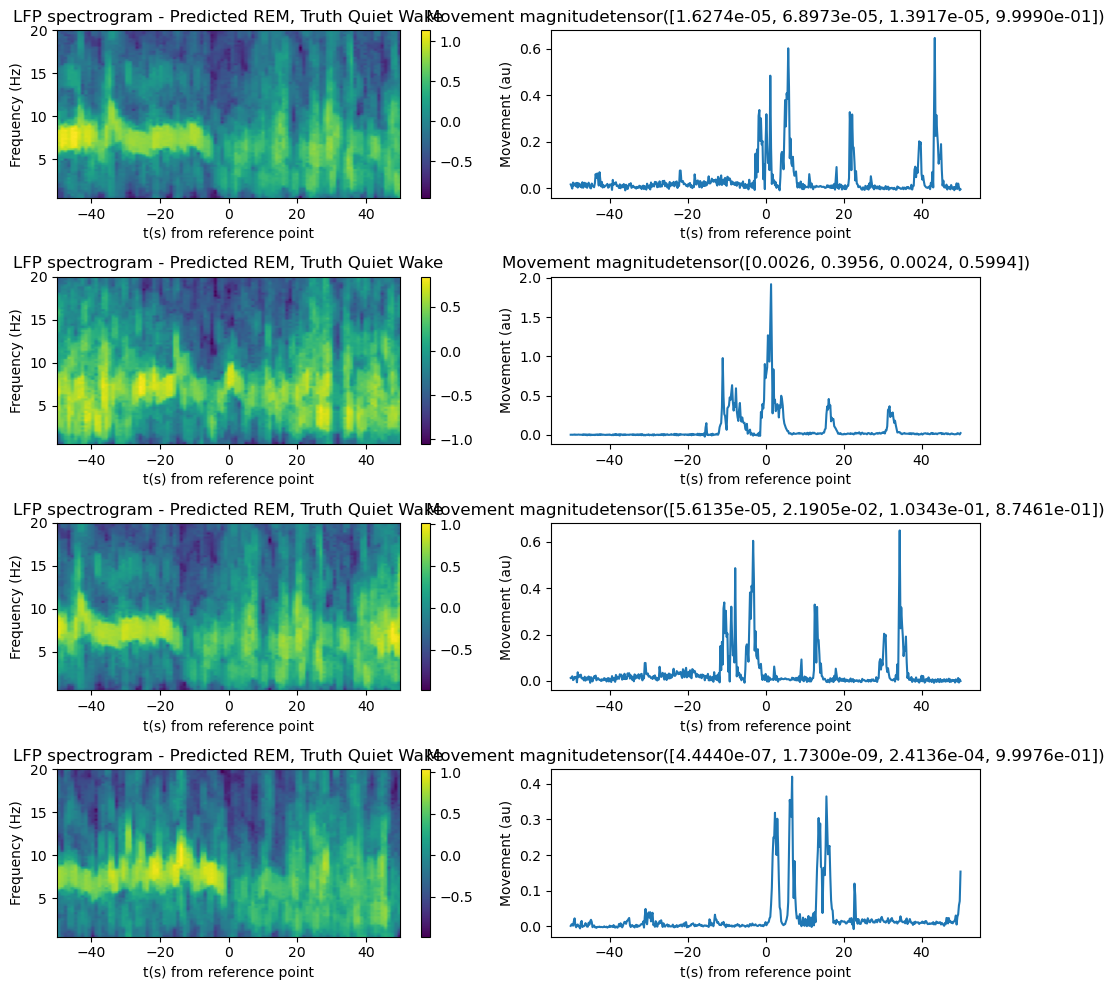

In [797]:
checkWrongNet(net_predictions,target_val_res-1,3,1,spectral_norm_val_res,mov_norm_val_res,output_net)

# Conclusions

The accuracy of the two developed models is quite comparable. Taking a closer look at accuracies for the different classes it is apparent that the CNN performs slightly better on identifying quiet wake states than the Random Forest, whereas the latter outperforms the CNN in classifying Wake states.
It should be mentioned that the distinction between the quiet wake and NREM sleep states is not straightforward. There is surely a certain level of uncertainty in the labeling of the quiet wake state since it is not possible to identify the axact transition point between QW and sleep solely based on the parameters used.

Overall, given the comparable performance of the models tested, following the law of parsimony I would take the Random Forest as the model of choice.

# Remarks for future versions of the brain state classifier

The approaches employed exhibit promising potential, yet there remains ample room for refinement. One salient aspect that merits further scrutiny pertains to the fine-tuning of additional hyperparameters within the CNN, including the number of hidden layers.
Upon a brief examination of misclassified instances, it became apparent that a considerable proportion of predictive errors stem from uncertainties inherent in the labelling of the Quiet Wake state. This observation implies that the models perform closer to human-level accuracy than the raw accuracy values might suggest. Additionally, a source of errors seems to emanate from imprecision in defining the reference time point for classification in each instance, which can be identified as the zero-time point in the plots. For instance, consider the example of misclassified QW vs REM in the CNN model. Explicitly demarcating this time point from its surroundings could bolster the accuracy of future iterations of the models.

It is widely acknowledged that transitions between different states random. For instance, a REM sleep episode never follows a Wake state and generally precedes a brief period of Quiet Wakefulness. Establishing well-defined rules governing the "allowed" transitions between states may prove to be an efficacious approach for enhancing predictive performance post hoc.

Another strategy to further improve predictive performance and generalizabity is expanding the training dataset to encompass a larger cohort of animals.